# Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from IPython.display import display, HTML
import math

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore') # Ignore all warnings

In [2]:
def multiple_histogram(data, hue_feature, h=1600, w=1100):
    unique_hues = data[hue_feature].unique()  # Get unique categories in hue feature
    num_row = math.ceil(len(data.drop(hue_feature, axis = 1).columns) / 3)
    fig = make_subplots(rows=num_row, cols=3, subplot_titles=(data.drop(hue_feature, axis = 1).columns))

    place_col = 1
    place_row = 1
    for i in data.drop(hue_feature, axis = 1).columns:
        if i != hue_feature:  # Don't plot hue feature itself
            for hue in unique_hues:
                filtered_data = data[data[hue_feature] == hue]  # Filter by each hue category
                fig.add_trace(go.Histogram(x=filtered_data[i], name=f"{i} - {hue}",
                                           opacity=0.6),  # Add some transparency for overlay
                              row=place_row, col=place_col)

            place_col += 1
            if place_col == 4:
                place_col = 1
                place_row += 1

    fig.update_layout(height=h, width=w,
                      title_text="Multiple Histograms with Hue",
                      barmode="overlay")  # Overlay histograms
    return fig



def multiple_boxplot(data):

    num_row = math.ceil(len(data.columns) / 3)
    fig = make_subplots(rows=num_row, cols=3,subplot_titles=(data.columns))

    place_col = 1
    place_row = 1
    for i in data.columns:

        fig.add_trace(go.Box(y=data[i]),row=place_row, col=place_col)

        place_col += 1
        if place_col == 4:
            place_col = 1
            place_row += 1
    return fig.update_layout(height=1600, width=1100,
                          title_text="Multiple Histogram for all featrues")

def split_name(X_data, separator):

    for i in range(len(X_data.columns)):

        if  separator in X_data.columns[i]:

            new_name = X_data.columns[i].split(separator)[1]
            X_data.rename(columns={X_data.columns[i]:new_name}, inplace=True)

def check_nulls(X_data):

    unusual_nulls = X_data[X_data.isin(['{}','[]', "?", ".", "-", "_", "", " ", "  "])].sum()

    nulls_df = pd.concat([X_data.isna().sum(), unusual_nulls], axis=1)
    nulls_df.columns = ["usual_nulls", "strange_nulls"]
    nulls_df = nulls_df.sort_values('usual_nulls', ascending = False)
    return nulls_df

def unuseful_featuers(X_data, sum_of_nulls):
    columns_Most_NUll = []
    for c in prep_df.columns:
        if (prep_df[c].isna().sum()) > sum_of_nulls:
            columns_Most_NUll.append(c)
    return columns_Most_NUll

def remove_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df_no_outliers

def onehot_encode(data, column):
    df = data.copy()
    dummies = pd.get_dummies(df[column], prefix=column,dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

# Typical Accuracy Ranges for Human Prediction:

Experience and Intuition:

`
1- Experienced HR professionals might have a gut feeling about potential attrition based on interactions and observations, leading to an accuracy range of about 60% to 75%.
`
######

Structured Insights:

`
2- When HR relies on structured data (like surveys, performance reviews, and engagement metrics) along with their intuition, they may achieve accuracy rates of around 75% to 85%.
`

# Read & Inspect Data

In [3]:
emp_df = pd.read_csv('HR-Employee-Attrition.csv')

In [4]:
emp_df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0


In [5]:
emp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
emp_df.isna().sum()

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [7]:
emp_df.duplicated().sum()

0

In [8]:
for feature in emp_df:
    print({ feature: emp_df[feature].nunique() })

{'Age': 43}
{'Attrition': 2}
{'BusinessTravel': 3}
{'DailyRate': 886}
{'Department': 3}
{'DistanceFromHome': 29}
{'Education': 5}
{'EducationField': 6}
{'EmployeeCount': 1}
{'EmployeeNumber': 1470}
{'EnvironmentSatisfaction': 4}
{'Gender': 2}
{'HourlyRate': 71}
{'JobInvolvement': 4}
{'JobLevel': 5}
{'JobRole': 9}
{'JobSatisfaction': 4}
{'MaritalStatus': 3}
{'MonthlyIncome': 1349}
{'MonthlyRate': 1427}
{'NumCompaniesWorked': 10}
{'Over18': 1}
{'OverTime': 2}
{'PercentSalaryHike': 15}
{'PerformanceRating': 2}
{'RelationshipSatisfaction': 4}
{'StandardHours': 1}
{'StockOptionLevel': 4}
{'TotalWorkingYears': 40}
{'TrainingTimesLastYear': 7}
{'WorkLifeBalance': 4}
{'YearsAtCompany': 37}
{'YearsInCurrentRole': 19}
{'YearsSinceLastPromotion': 16}
{'YearsWithCurrManager': 18}


`
Features EmployeeCount, StandardHours and Over18 all have only one value, And EmployeeNumber is not important, So, Drop them
`

In [9]:
emp_df.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber','Over18'], axis=1, inplace=True)

In [10]:
data = emp_df.copy()

# EDA & Preprocessing fro Bais Model

In [11]:
cat_data = data.select_dtypes(include='object')
num_data = data.select_dtypes(exclude='object')

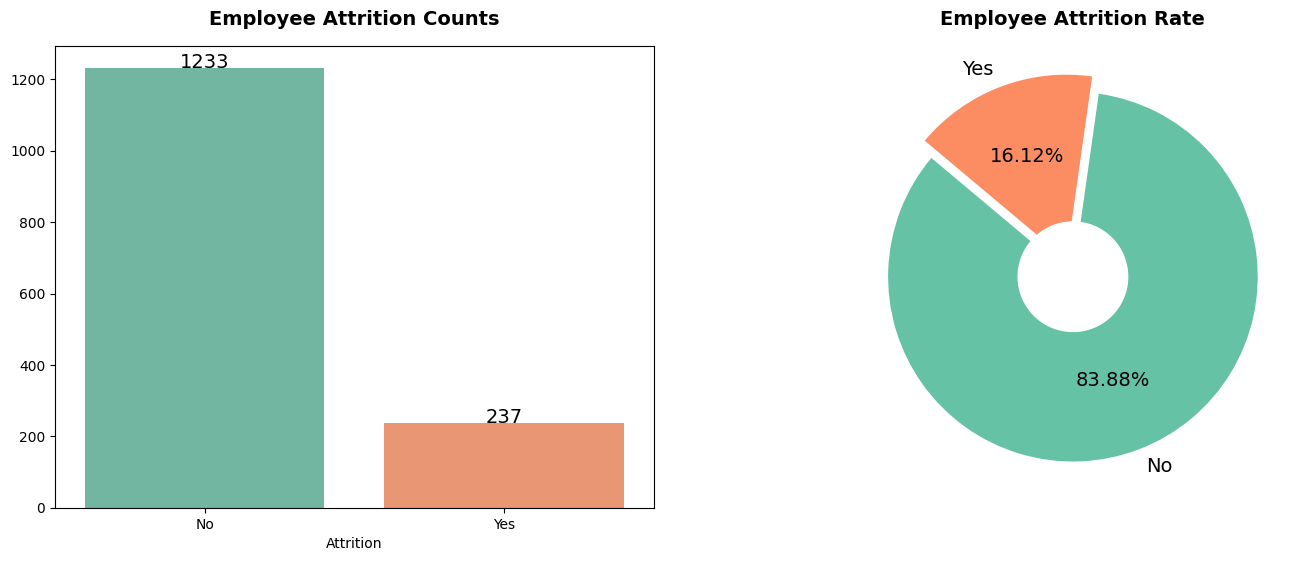

In [12]:
plt.figure(figsize=(17,6))
# Barplot to show Employee Attrition in Counts.
plt.subplot(1,2,1)
attrition_rate = cat_data["Attrition"].value_counts()
sns.barplot(x=attrition_rate.index,y=attrition_rate.values,palette= 'Set2')
plt.title("Employee Attrition Counts",fontweight="black", size=14, pad=15)
for i, v in enumerate(attrition_rate.values):
    plt.text(i, v, v,ha="center", fontsize=14)

# Pieplot to show Employee Attrition in Percentage.
plt.subplot(1,2,2)
colors = sns.color_palette('Set2', len(attrition_rate))
plt.pie(attrition_rate, labels=["No","Yes"], autopct="%.2f%%", textprops={"size":14},
        colors = colors,explode=[0,0.1],startangle=140)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Employee Attrition Rate",fontweight="black",size=14 ,pad=15)
plt.show()

`this data is unbalanced`

In [13]:
# Ensure that 'df' is your DataFrame
cm = num_data.corr() # Select the numeric columns from the DataFrame before calculating the correlation

cols = cm.columns

fig = px.imshow(
    cm, x=cols, y=cols, color_continuous_scale='viridis', title='Correlation Heatmap',
     # Adjust these values as needed
)

fig.update_layout(
    width=900,
    height=800
)
# Rotate x-axis labels for better readability
fig.update_xaxes(tickangle=-45)

fig.show()

`
TotalWorkingYears has high multicolliniarity with other featears, So, can dorp it
`

In [14]:
multiple_histogram(pd.concat([num_data, cat_data['Attrition']], axis=1), hue_feature='Attrition')

`
The histplot of both YearsWithCurrManager and YearsInCurrentRole looks similare and also have high correlation with YearsAtCompany
`

In [15]:
fig = px.scatter(
    data,
    x='YearsAtCompany',
    y='MonthlyIncome',
    title='Scatter Plot of MonthlyIncome vs. Job YearsAtCompany',
)

fig.update_layout(
    xaxis_title='YearsAtCompany',
    yaxis_title='MonthlyIncome',
    width=900,
    height=400
)

fig.show()


# Encoding

In [16]:
label_encoder = LabelEncoder()
cat_data['Gender'] = label_encoder.fit_transform(cat_data['Gender'])
cat_data['Attrition'] = label_encoder.fit_transform(cat_data['Attrition'])
cat_data['OverTime'] = label_encoder.fit_transform(cat_data['OverTime'])

In [17]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
for feature in cat_data.select_dtypes(include='object').columns:
    # Fit and transform the feature
    encoded_array = one_hot_encoder.fit_transform(cat_data[[feature]])

    # Create a DataFrame from the encoded array
    encoded_df = pd.DataFrame(encoded_array, columns=one_hot_encoder.get_feature_names_out([feature]))
    encoded_df = encoded_df.astype(int)

    # Concatenate the original DataFrame with the new encoded DataFrame
    cat_data = pd.concat([cat_data.reset_index(drop=True), encoded_df], axis=1)

    # Drop the original categorical column
    cat_data.drop(columns=[feature], axis = 1, inplace=True)

In [18]:
cat_data.shape

(1470, 27)

In [19]:
cat_data.head(3)

,Attrition,Gender,OverTime,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [20]:
stats = num_data.describe().T

Q1 = stats['25%']
Q3 = stats['75%']
IQR = Q3 - Q1

result = 1.5 * IQR + Q3

c=0
for i ,j in zip(result, stats['max']):
    print({stats.index[c]:[ f'1.5 * IQR + Q3 = {i}',  f'max = {j}']})
    c += 1

{'Age': ['1.5 * IQR + Q3 = 62.5', 'max = 60.0']}
{'DailyRate': ['1.5 * IQR + Q3 = 2195.0', 'max = 1499.0']}
{'DistanceFromHome': ['1.5 * IQR + Q3 = 32.0', 'max = 29.0']}
{'Education': ['1.5 * IQR + Q3 = 7.0', 'max = 5.0']}
{'EnvironmentSatisfaction': ['1.5 * IQR + Q3 = 7.0', 'max = 4.0']}
{'HourlyRate': ['1.5 * IQR + Q3 = 137.375', 'max = 100.0']}
{'JobInvolvement': ['1.5 * IQR + Q3 = 4.5', 'max = 4.0']}
{'JobLevel': ['1.5 * IQR + Q3 = 6.0', 'max = 5.0']}
{'JobSatisfaction': ['1.5 * IQR + Q3 = 7.0', 'max = 4.0']}
{'MonthlyIncome': ['1.5 * IQR + Q3 = 16581.0', 'max = 19999.0']}
{'MonthlyRate': ['1.5 * IQR + Q3 = 39083.25', 'max = 26999.0']}
{'NumCompaniesWorked': ['1.5 * IQR + Q3 = 8.5', 'max = 9.0']}
{'PercentSalaryHike': ['1.5 * IQR + Q3 = 27.0', 'max = 25.0']}
{'PerformanceRating': ['1.5 * IQR + Q3 = 3.0', 'max = 4.0']}
{'RelationshipSatisfaction': ['1.5 * IQR + Q3 = 7.0', 'max = 4.0']}
{'StockOptionLevel': ['1.5 * IQR + Q3 = 2.5', 'max = 3.0']}
{'TotalWorkingYears': ['1.5 * IQR + Q3

In [21]:
data = pd.concat([num_data, cat_data], axis= 1)

In [22]:
data.shape

(1470, 50)

In [23]:
# data = remove_outliers(data, 'MonthlyIncome')
data = remove_outliers(data, 'TotalWorkingYears')
# data = remove_outliers(data, 'YearsAtCompany')

In [24]:
data.shape

(1407, 50)

# Base Model

In [25]:
x = data.drop('Attrition', axis=1)
y = data['Attrition']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = pd.DataFrame(data = scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(data = scaler.transform(x_test), columns=x_test.columns)

In [26]:
tsne_projection = TSNE(n_components=2,
                       perplexity=2,
                       learning_rate=1,
                       init='pca',
                       method='barnes_hut',
                       n_jobs=-1,
                       n_iter=10**4,
                       random_state=42).fit_transform(x_train)

tsne_projection = pd.DataFrame(tsne_projection, columns=['feature1', 'feature2'],index=y_train.index.tolist())
tsne_projection['y_true'] = y_train.tolist()
tsne_projection.head()

px.scatter(tsne_projection, x='feature1', y='feature2', color="y_true", title='x_train & y_train')

In [27]:
x_train.shape

(1125, 49)

In [28]:
n = 40
pca = PCA(n_components=n)
principal_components = pca.fit_transform(x_train)

In [29]:
PCA_columns = ['PC'+str(i) for i in range(1, n+1)]

# Convert the principal components to a DataFrame for visualization
x_train_PCA = pd.DataFrame(data=principal_components, columns=PCA_columns)

x_train_PCA.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,1.427420,-0.861062,0.218000,-2.300300,0.370811,-1.973380,2.596294,-0.167729,1.616260,-1.853139,-1.004862,0.267092,-0.823646,1.725532,-0.864280,2.296021,-0.750310,-0.343358,-2.045877,1.177439,0.708772,0.070631,-0.972073,0.503813,0.059368,-0.155040,0.462388,0.294122,-1.671281,0.401157,0.372051,-1.315942,-1.337345,-1.635855,-1.219505,-0.892092,0.574112,-0.844107,-0.897566,-0.106559
1,0.973537,1.504782,-0.110042,0.440670,-1.416823,1.889161,-0.947260,-0.119228,-0.380307,0.897116,-0.380986,0.311991,1.049381,2.904732,-1.440318,-1.465024,2.916751,-1.096160,-0.365348,0.095171,0.130966,1.070789,0.290339,-0.908570,-0.346191,-1.383700,-1.011533,-0.591220,-0.399219,-1.294282,0.406589,-1.056148,-0.413305,0.662435,-0.262643,0.758451,0.213343,0.200336,-0.607435,-0.213319
2,-1.275427,-1.039145,5.536188,1.461118,2.176246,1.122714,0.748523,-1.530359,0.653560,0.404120,1.688743,-0.176478,0.469166,-0.201939,0.881085,-1.304637,0.389226,0.070938,0.652992,0.551285,0.273608,0.978946,-0.352922,-0.055036,-0.693900,0.448082,1.635039,-1.101236,0.783800,1.801261,0.254106,0.124818,2.046738,0.813974,-2.971978,0.682491,0.238709,-0.975958,0.182414,0.176954
3,1.394826,1.569898,0.279783,-2.622493,-0.875743,-2.710488,-0.943677,-2.133546,0.779157,-0.624801,-0.538554,-1.639132,1.243694,0.131454,3.895807,-1.064582,0.539607,1.109122,0.219347,-0.334520,-0.593817,-0.276229,0.646935,-0.701553,-2.201467,-0.819083,-1.604431,0.835616,1.541683,-0.819571,-0.030501,-0.564637,-0.058417,0.324377,0.077038,0.042724,0.110859,-0.204080,0.607037,-0.185872
4,-3.314004,0.724866,-0.517342,0.097002,1.950157,0.881769,-0.197393,1.396289,0.694981,-0.063940,-1.155793,-0.362058,-0.597934,0.529067,0.220826,1.190215,-0.907197,0.020637,0.689161,-0.495216,-0.150389,-0.771042,1.266102,0.480524,1.886073,-0.432003,1.180928,-0.132630,-0.068126,-0.641077,-0.249886,0.447860,0.351108,0.615376,0.296517,0.520316,0.088704,-0.221154,-0.176395,0.203667


In [30]:
principal_components = pca.transform(x_test)
x_test_PCA = pd.DataFrame(data=principal_components, columns=PCA_columns)

x_test_PCA.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,-0.967909,-1.998397,9.726492,0.513429,1.964343,0.990391,0.617335,0.537069,-0.894564,-0.428494,0.252343,-0.192763,0.235510,-0.062934,1.204890,-0.204842,-0.870016,-1.292052,0.798605,-0.370442,0.705105,-0.337233,0.969626,-0.440517,0.933388,-0.486748,-0.971996,-0.342814,-1.708361,-0.112888,0.419867,0.142777,-0.662997,-0.119830,2.348442,-0.838248,0.311434,0.644420,-0.246214,-0.223668
1,0.649821,-3.020165,-0.513625,1.645243,-1.118856,-1.719131,-1.149258,-0.662544,1.082373,-0.301341,-0.369436,-1.325198,-0.981569,-2.083535,-0.513073,0.636510,0.338012,0.291941,-0.180588,-0.656197,1.529263,3.028358,-0.212462,-2.611665,-2.297153,-0.662351,0.092540,-0.034369,-1.670923,0.053127,-0.627949,2.070130,-0.824161,-0.210070,-0.417711,-0.893624,0.018148,-0.118169,0.530726,-0.656198
2,1.924074,2.078153,0.014101,0.678815,-0.990023,0.419196,0.425084,1.502525,2.127645,-0.671714,2.795300,-0.397090,-0.480113,-0.665274,-0.685982,0.531924,-0.564975,-0.486092,0.211396,0.712320,0.105640,-0.205964,-0.873221,-0.943384,-1.055769,-1.435275,0.258703,0.099687,-2.009073,-0.504525,-2.189879,0.476999,0.846837,-2.403240,-0.443518,-0.836526,-0.766095,-0.355473,1.192385,-0.073462
3,-1.875676,1.281126,-0.915343,1.943126,1.161373,0.004836,2.698021,0.743098,1.372652,0.704957,-0.940549,-0.781985,0.366160,1.251767,0.442857,1.262735,0.901410,0.317147,-0.376430,0.398291,0.868298,-0.889254,0.057745,-0.756950,-0.271454,-0.665098,0.080535,0.130133,0.782874,0.100471,-0.641547,0.112571,-0.648783,-0.128146,-0.200053,0.193481,0.381249,0.796213,-0.628997,0.197510
4,-2.731989,1.201785,-0.336190,0.430075,-2.620677,0.724063,2.708365,-2.511753,-0.471952,0.298852,-0.787290,-0.810789,-0.660122,0.977228,0.396083,0.077138,0.489510,0.557351,-0.444432,0.336535,0.558833,0.226613,-1.243035,0.857937,1.720723,1.022788,1.237222,0.452539,2.207943,0.598130,-0.326672,0.006400,-1.590765,0.093004,-0.067483,0.584413,-0.146141,0.015428,-0.152614,-0.092259


In [31]:
tsne_projection = TSNE(n_components=2,
                       perplexity=2,
                       learning_rate=1,
                       init='pca',
                       method='barnes_hut',
                       n_jobs=-1,
                       n_iter=10**4,
                       random_state=42).fit_transform(x_train_PCA)

tsne_projection = pd.DataFrame(tsne_projection, columns=['feature1', 'feature2'],index=y_train.index.tolist())
tsne_projection['y_true'] = y_train.tolist()
tsne_projection.head()

px.scatter(tsne_projection, x='feature1', y='feature2', color="y_true", title='x_train_PCA & y_train')

In [32]:
x_train_PCA.shape, x_test_PCA.shape

((1125, 40), (282, 40))

## LogisticRegression Base Model

In [33]:
LRBM = LogisticRegression(penalty='l1', solver='liblinear')
LRBM.fit(x_train_PCA, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [34]:
y_pred_train = LRBM.predict(x_train_PCA)

<Axes: >

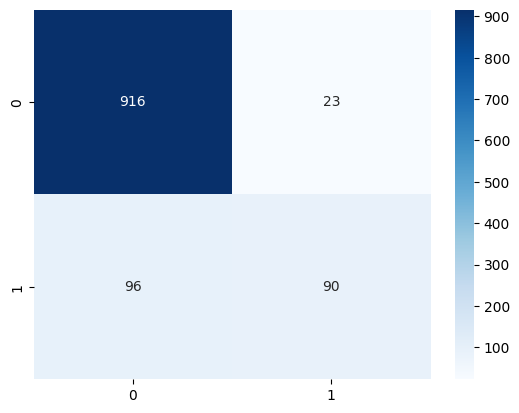

In [35]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [36]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       939
           1       0.80      0.48      0.60       186

    accuracy                           0.89      1125
   macro avg       0.85      0.73      0.77      1125
weighted avg       0.89      0.89      0.88      1125

accuracy = 0.89
racall = 0.48
precision = 0.80
F1_Score = 0.60


<Axes: >

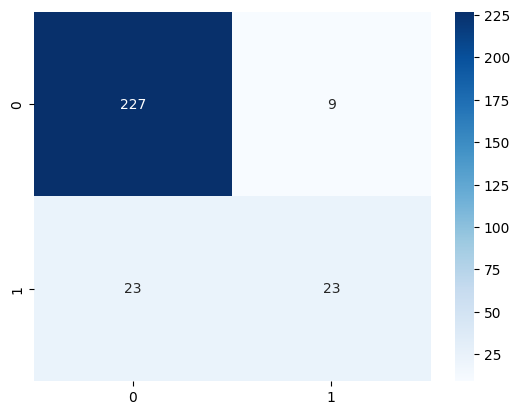

In [37]:
y_pred = LRBM.predict(x_test_PCA)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [38]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       236
           1       0.72      0.50      0.59        46

    accuracy                           0.89       282
   macro avg       0.81      0.73      0.76       282
weighted avg       0.88      0.89      0.88       282

accuracy = 0.89
racall = 0.50
precision = 0.72
F1_Score = 0.59


# Final Preprocessing

In [39]:
data2 = emp_df.copy()

In [40]:
data2.shape

(1470, 31)

In [41]:
cat_data = data2.select_dtypes(include='object')
num_data = data2.select_dtypes(exclude='object')

## detect outlayers

In [42]:
num_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.0,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0
MonthlyIncome,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.00,19999.0


In [43]:
stats = num_data.describe().T

Q1 = stats['25%']
Q3 = stats['75%']
IQR = Q3 - Q1

upper_limit = 1.5 * IQR + Q3

c=0
for i ,j in zip(upper_limit, stats['max']):
    print({stats.index[c]:[ f'upper_limit = {i}',  f'max = {j}']})
    c += 1

{'Age': ['upper_limit = 62.5', 'max = 60.0']}
{'DailyRate': ['upper_limit = 2195.0', 'max = 1499.0']}
{'DistanceFromHome': ['upper_limit = 32.0', 'max = 29.0']}
{'Education': ['upper_limit = 7.0', 'max = 5.0']}
{'EnvironmentSatisfaction': ['upper_limit = 7.0', 'max = 4.0']}
{'HourlyRate': ['upper_limit = 137.375', 'max = 100.0']}
{'JobInvolvement': ['upper_limit = 4.5', 'max = 4.0']}
{'JobLevel': ['upper_limit = 6.0', 'max = 5.0']}
{'JobSatisfaction': ['upper_limit = 7.0', 'max = 4.0']}
{'MonthlyIncome': ['upper_limit = 16581.0', 'max = 19999.0']}
{'MonthlyRate': ['upper_limit = 39083.25', 'max = 26999.0']}
{'NumCompaniesWorked': ['upper_limit = 8.5', 'max = 9.0']}
{'PercentSalaryHike': ['upper_limit = 27.0', 'max = 25.0']}
{'PerformanceRating': ['upper_limit = 3.0', 'max = 4.0']}
{'RelationshipSatisfaction': ['upper_limit = 7.0', 'max = 4.0']}
{'StockOptionLevel': ['upper_limit = 2.5', 'max = 3.0']}
{'TotalWorkingYears': ['upper_limit = 28.5', 'max = 40.0']}
{'TrainingTimesLastYear': 

In [44]:
numerical_cols = [col for col in num_data.drop(['Education', 'StockOptionLevel'
                                               ,'PerformanceRating'
                                               ,'RelationshipSatisfaction'
                                               ,'WorkLifeBalance'
                                               ,'JobSatisfaction'
                                                ,'EnvironmentSatisfaction'], axis=1).columns if num_data[col].dtype != 'object']  # Filter numerical columns

# Calculate the number of rows and columns for subplots
num_cols = len(numerical_cols)
num_rows = (num_cols + 3) // 4

# Create a subplots grid using make_subplots
fig = make_subplots(rows=num_rows, cols=4) # Remove figsize argument

# Iterate over numerical columns and create boxplots
col_counter = 0
for row in range(num_rows):
    for col in range(4):
        if col_counter < num_cols:
            current_col = numerical_cols[col_counter]
            trace = go.Box(
                y=num_data[current_col],
                name=current_col,
                boxmean=True  # Optional: show box mean line
            )
            fig.add_trace(trace, row=row + 1, col=col + 1)  # Add trace to subplot
            fig.update_xaxes(title_text="Features", row=row + 1, col=col + 1)  # Set x-axis title
            fig.update_yaxes(title_text=current_col, row=row + 1, col=col + 1)  # Set y-axis title
            col_counter += 1
        else:
            # Hide unused subplots (optional)
            fig.update_xaxes(visible=False, row=row + 1, col=col + 1)
            fig.update_yaxes(visible=False, row=row + 1, col=col + 1)

# Adjust layout (optional)
fig.update_layout(title="Boxplots of Numerical Features", width=1100, height=500*num_rows) # Set the width and height of the figure using update_layout

fig.show()

In [45]:
data2 = pd.concat([num_data, cat_data], axis=1)

In [46]:
data2 = remove_outliers(data2, 'TotalWorkingYears')
# data2 = remove_outliers(data2, 'MonthlyIncome')
# dat2 = remove_outliers(data2, 'Age')

## Encoding

In [47]:
# Label Encoding columns
label_encoder = LabelEncoder()
data2['Gender'] = label_encoder.fit_transform(data2['Gender'])
data2['Attrition'] = label_encoder.fit_transform(data2['Attrition'])
data2['OverTime'] = label_encoder.fit_transform(data2['OverTime'])

# Ordinal-encode the BusinessTravel column
oe = OrdinalEncoder(categories=[['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']])

# Fit the encoder to the data and transform the column
cat_data['BusinessTravel'] = oe.fit_transform(cat_data[['BusinessTravel']])


# One-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
for feature in data2.select_dtypes(include='object').columns:
    # Fit and transform the feature
    encoded_array = one_hot_encoder.fit_transform(data2[[feature]])

    # Create a DataFrame from the encoded array
    encoded_df = pd.DataFrame(encoded_array, columns=one_hot_encoder.get_feature_names_out([feature]))
    encoded_df = encoded_df.astype(int)

    # Concatenate the original DataFrame with the new encoded DataFrame
    data2 = pd.concat([data2.reset_index(drop=True), encoded_df], axis=1)

    # Drop the original categorical column
    data2.drop(columns=[feature], axis = 1, inplace=True)

In [48]:
data2.head(3)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Gender,OverTime,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [49]:
data2.shape

(1407, 50)

## Feature Engneering

`
Based on the histogram distribution of the YearsWithCurrManager and YearsInCurrentRole and thier relation with YearsAtCompany
`

`
We will create 2 features that have the ratio of both with the YearsAtCompany, And let the PCA take the best of these 5 featuers
`

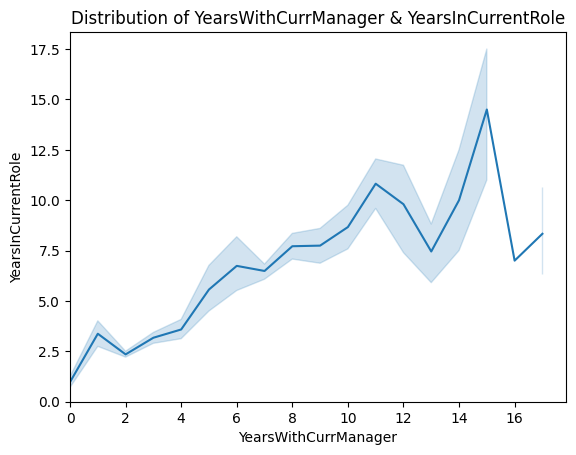

In [50]:
sns.lineplot(data2, x='YearsWithCurrManager', y='YearsInCurrentRole')
plt.title('Distribution of YearsWithCurrManager & YearsInCurrentRole')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [51]:
data2[['YearsWithCurrManager', 'YearsInCurrentRole']].head()

,YearsWithCurrManager,YearsInCurrentRole
0,5,4
1,7,7
2,0,0
3,0,7
4,2,2


In [52]:
(data2['YearsAtCompany']<12).sum()/len(data2) * 100

86.99360341151386

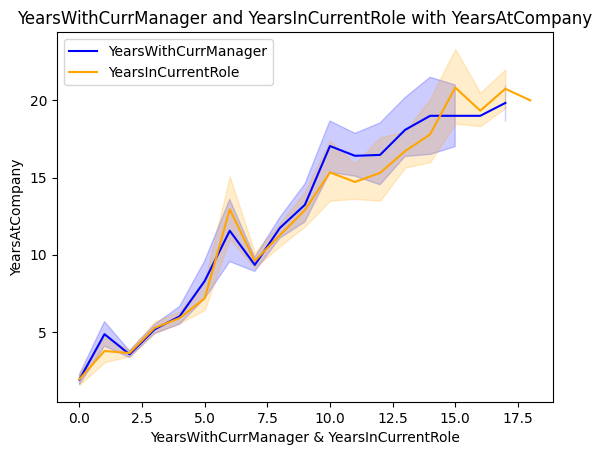

In [53]:
sns.lineplot(data2, x='YearsWithCurrManager', y='YearsAtCompany', color='blue', label='YearsWithCurrManager')
sns.lineplot(data2, x='YearsInCurrentRole', y='YearsAtCompany', color = 'orange', label='YearsInCurrentRole')
plt.title('YearsWithCurrManager and YearsInCurrentRole with YearsAtCompany')
plt.legend(handlelength=2, markerscale=2, loc= 'upper left')
plt.xlabel('YearsWithCurrManager & YearsInCurrentRole')
plt.ylabel('YearsAtCompany')
plt.show()

`
calc the ratio of (YearsWtihCurrManager/YearsAtCompany) and (YearsInCurrentRole/YearsAtCompany)
`

In [54]:
RatioMangComp = [ np.round(j/i, 2) if i != 0 else 0 for i, j in zip(data2['YearsAtCompany'], data2['YearsWithCurrManager'])]
data2['RatioMangComp'] = RatioMangComp

RatioRoleComp = [ np.round(j/i, 2) if i != 0 else 0 for i, j in zip(data2['YearsAtCompany'], data2['YearsInCurrentRole'])]
data2['RatioRoleComp'] = RatioRoleComp

In [55]:
data2[['HourlyRate', 'DailyRate', 'MonthlyRate', 'MonthlyIncome', 'OverTime', 'Attrition']].head(5)

,HourlyRate,DailyRate,MonthlyRate,MonthlyIncome,OverTime,Attrition
0,94,1102,19479,5993,1,1
1,61,279,24907,5130,0,0
2,92,1373,2396,2090,1,1
3,56,1392,23159,2909,1,0
4,40,591,16632,3468,0,0


In [56]:
multiple_histogram(data=data2[['HourlyRate', 'DailyRate', 'MonthlyRate', 'Attrition']], hue_feature='Attrition', h=400, w=1100)

`
[HourlyRate, DailyRate, MonthlyRate] These features have no clear realations and don't make sense, So, Drop it
`

`
Drop unneeded features
`

In [57]:
# data2.drop(['HourlyRate', 'DailyRate', 'MonthlyRate', 'YearsSinceLastPromotion',
#                 'TotalWorkingYears', 'YearsWithCurrManager', 'YearsInCurrentRole', 'YearsAtCompany'], axis=1, inplace=True)
# data2.drop(['HourlyRate', 'DailyRate', 'MonthlyRate', 'YearsWithCurrManager', 'YearsInCurrentRole'], axis=1, inplace=True)
data2.drop(['HourlyRate', 'DailyRate', 'MonthlyRate'], axis=1, inplace=True)
# data2.drop(['HourlyRate', 'DailyRate', 'MonthlyRate',
#                 'YearsWithCurrManager', 'YearsInCurrentRole', 'YearsAtCompany'], axis=1, inplace=True)

In [58]:
hasPormotionLast5Years = [ 1 if i < 6 else 0  for i in data2['YearsSinceLastPromotion']]

In [59]:
data2['hasPormotionLast5Years'] = hasPormotionLast5Years

In [60]:
data2.drop(['YearsSinceLastPromotion'], axis=1, inplace=True)

In [61]:
data2.shape

(1407, 49)

## Split Data

In [62]:
x = data2.drop('Attrition', axis=1)
y = data2['Attrition']

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = pd.DataFrame(data = scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(data = scaler.transform(x_test), columns=x_test.columns)

In [64]:
tsne_projection = TSNE(n_components=2,
                       perplexity=2,
                       learning_rate=1,
                       init='pca',
                       method='barnes_hut',
                       n_jobs=-1,
                       n_iter=10**4,
                       random_state=42).fit_transform(x_train)

In [65]:
tsne_projection = pd.DataFrame(tsne_projection, columns=['feature1', 'feature2'],index=y_train.index.tolist())
tsne_projection['y_true'] = y_train.tolist()
tsne_projection.head()

,feature1,feature2,y_true
108,-14.485599,22.822550,0
512,-10.285938,3.683746,0
141,116.908211,10.257658,0
1093,49.467251,93.684593,0
1246,14.564664,-108.345009,0


In [66]:
px.scatter(tsne_projection, x='feature1', y='feature2', color="y_true", title='x_train & y_train')

## Feature reduction PCA

In [67]:
n = 40
pca = PCA(n_components=n)
principal_components = pca.fit_transform(x_train)

In [68]:
PCA_columns = ['PC'+str(i) for i in range(1, n+1)]

# Convert the principal components to a DataFrame for visualization
x_train_PCA = pd.DataFrame(data=principal_components, columns=PCA_columns)

x_train_PCA.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,-2.149441,0.805102,-0.297706,0.914837,-0.728623,0.933246,-0.327105,0.695045,2.257656,-0.977780,1.801178,-0.160044,-0.444031,-0.339731,-1.026510,-0.065067,-0.438855,0.854074,-0.418725,0.349878,-1.034521,0.790310,0.751145,-0.360941,-0.121865,1.127655,0.100422,-0.053828,0.127336,0.269993,-0.682139,-0.214825,-0.028812,0.027707,-0.182105,0.385296,0.167844,-0.167720,0.120349,0.074216
1,2.183107,1.721993,-0.948415,-0.399837,2.316268,0.982977,0.009419,0.182270,-0.065856,-0.390337,0.712434,1.906610,-1.198466,-1.825516,0.234350,-0.727182,0.164239,-0.404916,0.477223,2.434260,-2.029696,-0.874800,-0.140123,0.467598,0.019579,-1.995299,1.159975,0.490455,-1.330023,-1.747814,0.540215,-2.929832,0.302026,0.208640,0.210437,-0.544861,-0.380878,-0.507333,-0.061549,0.022596
2,4.273332,1.667364,0.477194,-0.769659,0.382287,-2.065913,-1.801372,0.013067,0.070562,-1.596523,0.368399,-0.999922,-0.770206,0.673351,1.017473,1.431610,-0.753439,0.853998,-0.574155,-2.204439,0.063907,-0.604271,-1.156358,-2.420922,-1.267300,0.093964,-1.563854,-0.679055,-0.316962,-2.338446,1.265597,-1.229116,0.286105,-0.381096,-0.545621,-0.144548,0.019976,-0.511980,-0.438227,0.074380
3,1.732409,1.664720,-0.482193,2.326273,-1.680649,1.582260,-0.341440,-0.839834,0.020945,1.384509,-0.146445,0.813258,-0.397771,1.079093,-0.357034,-0.568030,-0.810019,0.986144,-0.698663,0.404198,2.888567,0.140007,0.938798,0.839618,0.121505,-0.771542,-1.802828,-0.036737,0.160934,-1.816687,0.557914,-0.790651,0.535069,0.342015,1.753123,0.150229,-0.232386,-0.403535,-0.089063,-0.046266
4,0.912930,-3.760750,-0.388092,0.066302,-1.227763,-1.598332,-1.020074,-0.626522,0.889476,1.569385,-0.526043,0.879193,-1.343035,-0.651702,0.454811,1.169486,0.136461,0.347277,-0.700743,-0.314743,0.677009,-0.106133,0.759622,1.150942,-1.869006,0.689349,-0.276275,1.938665,1.100814,-0.657881,-0.080871,-0.840832,-0.253699,-0.152917,0.935466,0.186944,0.485167,0.465652,-0.058569,-0.093080


In [69]:
principal_components = pca.transform(x_test)

In [70]:
x_test_PCA = pd.DataFrame(data=principal_components, columns=PCA_columns)

x_test_PCA.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,-1.431670,1.039287,0.057652,-0.165647,-0.559521,1.183233,-0.368536,0.795061,1.456383,1.117018,2.002531,1.021033,0.362217,-1.222896,0.920254,0.508125,-1.549544,0.371593,-0.405243,0.099764,0.107148,-1.158319,1.232858,0.586914,-0.358879,0.662686,-0.787344,-0.561323,1.014820,0.737565,0.199769,-0.410654,0.783355,0.403085,-0.950599,0.323840,-0.086166,-0.133336,0.200060,-0.050642
1,3.463278,1.676843,0.832325,-3.133508,-1.392306,0.664415,-0.915872,0.762979,1.396775,0.224759,0.034416,2.058675,-0.419346,-2.159543,-1.606027,-0.269555,0.935590,1.099228,-0.507540,-0.629114,-1.392644,-0.245767,0.393315,-1.952746,-0.345335,-1.325031,1.925895,-1.033345,-0.903728,0.160305,0.987822,-0.781501,0.322463,0.094900,0.148706,0.947887,0.501132,0.119235,-0.137843,-0.110920
2,-2.168694,1.139602,-0.199727,1.391990,-0.579832,-1.623818,-1.331209,-2.510500,-0.806801,-1.420787,-0.664532,0.042555,-2.144771,-0.981756,1.315856,-0.419745,-0.293688,-2.030591,0.992873,0.432470,-0.093800,0.653352,0.230616,0.250280,-2.078236,0.057909,-0.732776,0.625039,0.538110,0.286570,0.202109,-0.454695,-0.203510,0.093169,0.051537,0.109252,0.053856,0.008117,0.006032,-0.085102
3,1.921808,-3.182641,-1.631813,1.076473,2.445527,-1.385374,-0.081314,-1.129959,-0.470095,0.944898,0.741452,-0.369210,-0.693312,-0.719584,1.682352,1.489986,-0.076420,0.446274,0.038114,-0.018934,0.895059,0.283342,1.120856,0.884330,-0.765656,-0.830247,-0.089610,0.131082,0.780483,-0.175266,-0.043211,-2.743576,0.787623,0.228380,0.368825,-1.044725,0.032087,0.117683,-0.164322,-0.025786
4,1.310796,-3.224951,-1.637425,1.147069,1.703656,-2.371340,1.613732,-0.250494,-1.540891,0.624528,0.281352,-1.855749,2.026795,-0.655155,-1.628933,0.690710,-0.238353,1.263619,-1.320518,0.703588,1.191239,0.804728,0.145401,0.810352,0.890007,0.092427,0.564030,0.790102,0.029873,-0.228182,0.322468,-2.426765,0.289511,-0.157573,0.049599,0.614201,-0.435675,-0.351773,0.085482,0.089618


In [71]:
tsne_projection = TSNE(n_components=2,
                       perplexity=2,
                       learning_rate=1,
                       init='pca',
                       method='barnes_hut',
                       n_jobs=-1,
                       n_iter=10**4,
                       random_state=42).fit_transform(x_train_PCA)

In [72]:
tsne_projection = pd.DataFrame(tsne_projection, columns=['feature1', 'feature2'],index=y_train.index.tolist())
tsne_projection['y_true'] = y_train.tolist()
tsne_projection.head()

,feature1,feature2,y_true
108,-12.314815,24.803375,0
512,-8.224544,5.159918,0
141,122.516800,-5.494450,0
1093,36.962475,100.446922,0
1246,14.469012,-107.905212,0


In [73]:
px.scatter(tsne_projection, x='feature1', y='feature2', color="y_true", title='x_train_PCA & y_train')

# handle imbalanced Labels

In [74]:
value_counts = y_train.value_counts()
fig = px.pie(value_counts, values=value_counts.values, names=value_counts.index, color_discrete_sequence=px.colors.qualitative.Set2)
fig.show()

In [75]:
#smote = SMOTE(sampling_strategy=1)
smote = SMOTE(random_state=42)
x_train_PCA, y_train = smote.fit_resample(x_train_PCA, y_train)

In [76]:
value_counts = y_train.value_counts()
fig = px.pie(value_counts, values=value_counts.values, names=value_counts.index, color_discrete_sequence=px.colors.qualitative.Set2)
fig.show()

In [77]:
tsne_projection = TSNE(n_components=2,
                       perplexity=2,
                       learning_rate=1,
                       init='pca',
                       method='barnes_hut',
                       n_jobs=-1,
                       n_iter=10**4,
                       random_state=42).fit_transform(x_train_PCA)

In [78]:
tsne_projection = pd.DataFrame(tsne_projection, columns=['feature1', 'feature2'],index=y_train.index.tolist())
tsne_projection['y_true'] = y_train.tolist()
tsne_projection.head()

,feature1,feature2,y_true
0,-75.655785,12.489391,0
1,-53.074875,18.735479,0
2,145.533844,33.767147,0
3,29.540724,138.985458,0
4,34.283184,-86.573257,0


In [79]:
px.scatter(tsne_projection, x='feature1', y='feature2', color="y_true", title='x_train_PCA & y_train')

In [80]:
y_train.shape

(1644,)

# Modeling

## LogisticRegression

In [81]:
LRC = LogisticRegression(penalty='l1', solver='liblinear')
LRC.fit(x_train_PCA, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

<Axes: >

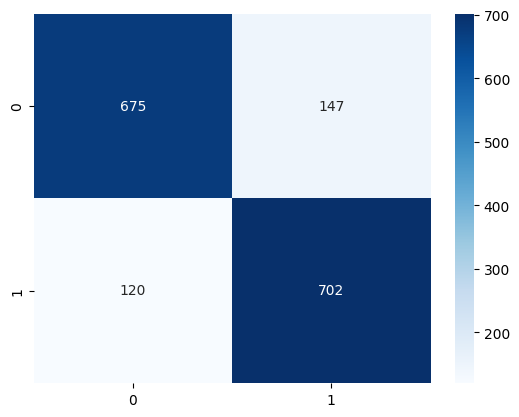

In [82]:
y_pred_train = LRC.predict(x_train_PCA)

cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [83]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       822
           1       0.83      0.85      0.84       822

    accuracy                           0.84      1644
   macro avg       0.84      0.84      0.84      1644
weighted avg       0.84      0.84      0.84      1644

accuracy = 0.84
racall = 0.85
precision = 0.83
F1_Score = 0.84


<Axes: >

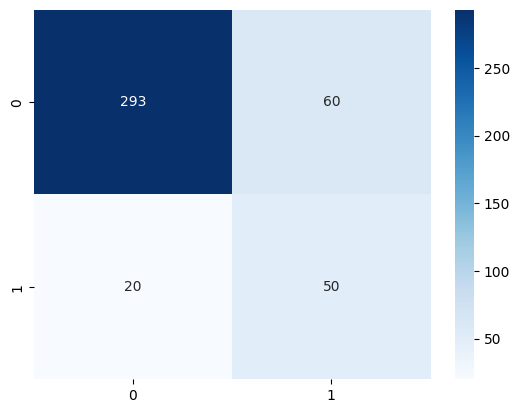

In [84]:
y_pred = LRC.predict(x_test_PCA)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [85]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       353
           1       0.45      0.71      0.56        70

    accuracy                           0.81       423
   macro avg       0.70      0.77      0.72       423
weighted avg       0.86      0.81      0.83       423

accuracy = 0.81
racall = 0.71
precision = 0.45
F1_Score = 0.56


## SVC

In [86]:
svc = SVC(C=1, gamma=0.003, kernel= 'rbf', random_state=42)
svc.fit(x_train_PCA, y_train)

SVC(C=1, gamma=0.003, random_state=42)

<Axes: >

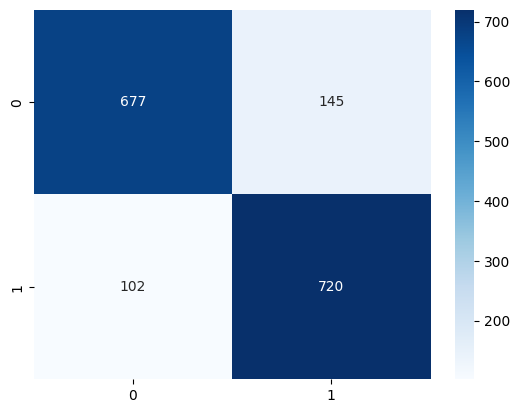

In [87]:
y_pred_train = svc.predict(x_train_PCA)

cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [88]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       822
           1       0.83      0.88      0.85       822

    accuracy                           0.85      1644
   macro avg       0.85      0.85      0.85      1644
weighted avg       0.85      0.85      0.85      1644

accuracy = 0.85
racall = 0.88
precision = 0.83
F1_Score = 0.85


<Axes: >

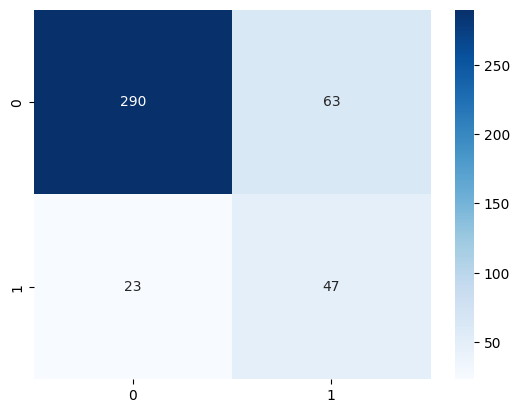

In [89]:
y_pred = svc.predict(x_test_PCA)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [90]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       353
           1       0.43      0.67      0.52        70

    accuracy                           0.80       423
   macro avg       0.68      0.75      0.70       423
weighted avg       0.84      0.80      0.81       423

accuracy = 0.80
racall = 0.67
precision = 0.43
F1_Score = 0.52


## KNN

In [91]:
knn = KNeighborsClassifier(n_neighbors=11)

knn.fit(x_train_PCA, y_train)

KNeighborsClassifier(n_neighbors=11)

<Axes: >

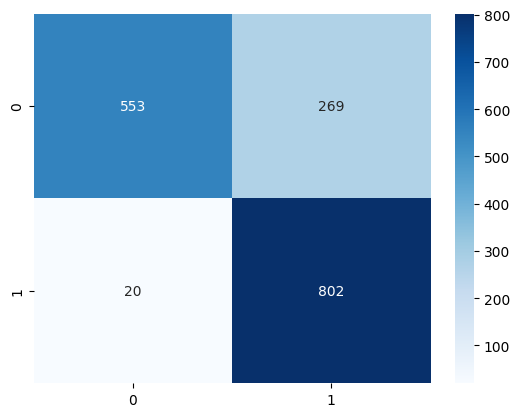

In [92]:
y_pred_train = knn.predict(x_train_PCA)
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [93]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.97      0.67      0.79       822
           1       0.75      0.98      0.85       822

    accuracy                           0.82      1644
   macro avg       0.86      0.82      0.82      1644
weighted avg       0.86      0.82      0.82      1644

accuracy = 0.82
racall = 0.98
precision = 0.75
F1_Score = 0.85


<Axes: >

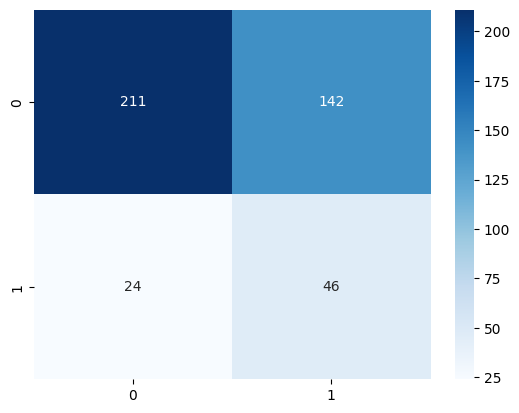

In [94]:
y_pred = knn.predict(x_test_PCA)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [95]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72       353
           1       0.24      0.66      0.36        70

    accuracy                           0.61       423
   macro avg       0.57      0.63      0.54       423
weighted avg       0.79      0.61      0.66       423

accuracy = 0.61
racall = 0.66
precision = 0.24
F1_Score = 0.36


## GaussianNB

In [96]:
GNB = GaussianNB()

GNB.fit(x_train_PCA, y_train)

GaussianNB()

<Axes: >

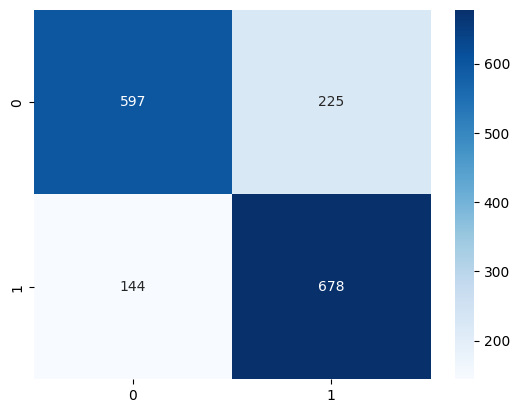

In [97]:
y_pred_train = GNB.predict(x_train_PCA)
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [98]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.81      0.73      0.76       822
           1       0.75      0.82      0.79       822

    accuracy                           0.78      1644
   macro avg       0.78      0.78      0.78      1644
weighted avg       0.78      0.78      0.78      1644

accuracy = 0.78
racall = 0.82
precision = 0.75
F1_Score = 0.79


<Axes: >

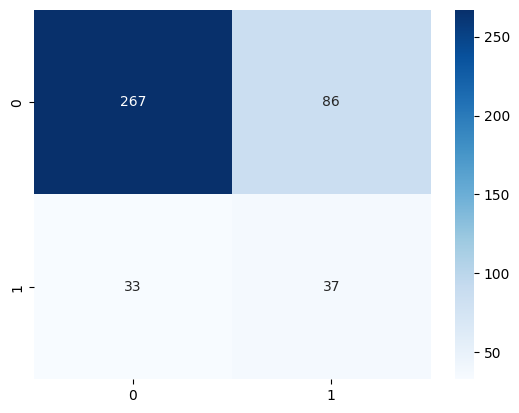

In [99]:
y_pred = GNB.predict(x_test_PCA)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [100]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       353
           1       0.30      0.53      0.38        70

    accuracy                           0.72       423
   macro avg       0.60      0.64      0.60       423
weighted avg       0.79      0.72      0.75       423

accuracy = 0.72
racall = 0.53
precision = 0.30
F1_Score = 0.38


## DecisionTreeClassifier

In [101]:
DTC = DecisionTreeClassifier(max_depth=5, random_state=42)

DTC.fit(x_train_PCA, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

<Axes: >

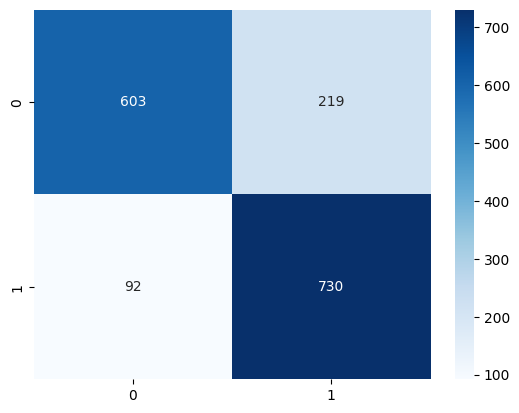

In [102]:
y_pred_train = DTC.predict(x_train_PCA)
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [103]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       822
           1       0.77      0.89      0.82       822

    accuracy                           0.81      1644
   macro avg       0.82      0.81      0.81      1644
weighted avg       0.82      0.81      0.81      1644

accuracy = 0.81
racall = 0.89
precision = 0.77
F1_Score = 0.82


<Axes: >

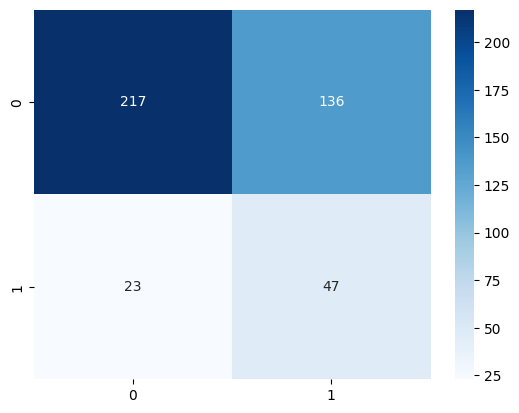

In [104]:
y_pred = DTC.predict(x_test_PCA)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [105]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.90      0.61      0.73       353
           1       0.26      0.67      0.37        70

    accuracy                           0.62       423
   macro avg       0.58      0.64      0.55       423
weighted avg       0.80      0.62      0.67       423

accuracy = 0.62
racall = 0.67
precision = 0.26
F1_Score = 0.37


## RandomForestClassifier

In [106]:
RF = RandomForestClassifier(n_estimators=1500, max_depth=5, max_features='sqrt', random_state=42)

RF.fit(x_train_PCA, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1500, random_state=42)

<Axes: >

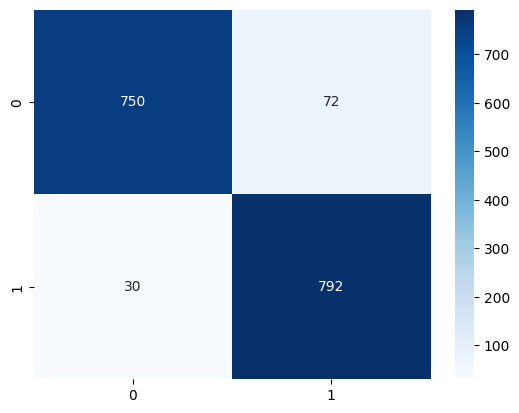

In [107]:
y_pred_train = RF.predict(x_train_PCA)
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [108]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       822
           1       0.92      0.96      0.94       822

    accuracy                           0.94      1644
   macro avg       0.94      0.94      0.94      1644
weighted avg       0.94      0.94      0.94      1644

accuracy = 0.94
racall = 0.96
precision = 0.92
F1_Score = 0.94


<Axes: >

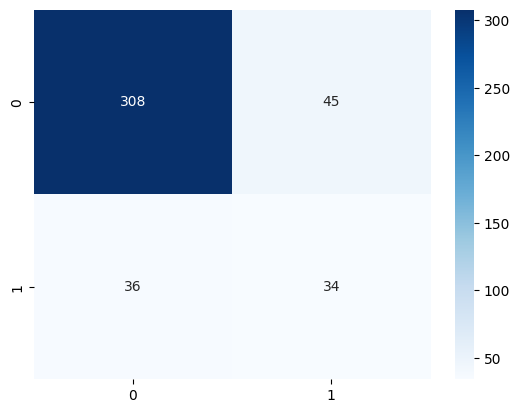

In [109]:
y_pred = RF.predict(x_test_PCA)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [110]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       353
           1       0.43      0.49      0.46        70

    accuracy                           0.81       423
   macro avg       0.66      0.68      0.67       423
weighted avg       0.82      0.81      0.81       423

accuracy = 0.81
racall = 0.49
precision = 0.43
F1_Score = 0.46


## AdaBoostClassifier

In [111]:
ABC = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.8, algorithm='SAMME', random_state=42)

ABC.fit(x_train_PCA, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.8, n_estimators=200, random_state=42)

<Axes: >

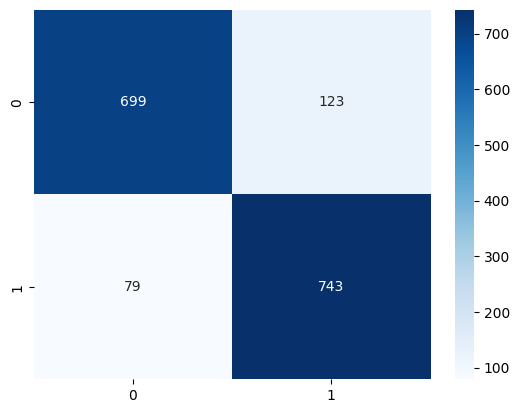

In [112]:
y_pred_train = ABC.predict(x_train_PCA)
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [113]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       822
           1       0.86      0.90      0.88       822

    accuracy                           0.88      1644
   macro avg       0.88      0.88      0.88      1644
weighted avg       0.88      0.88      0.88      1644

accuracy = 0.88
racall = 0.90
precision = 0.86
F1_Score = 0.88


<Axes: >

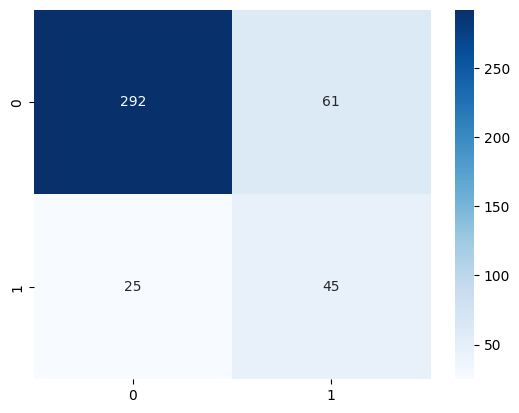

In [114]:
y_pred = ABC.predict(x_test_PCA)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [115]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       353
           1       0.42      0.64      0.51        70

    accuracy                           0.80       423
   macro avg       0.67      0.74      0.69       423
weighted avg       0.84      0.80      0.81       423

accuracy = 0.80
racall = 0.64
precision = 0.42
F1_Score = 0.51


## GradientBoostingClassifier

In [339]:
GBC = GradientBoostingClassifier(
    learning_rate=0.005,
    n_estimators=350,
    max_depth=3,
    random_state=42,
    max_features='sqrt'
)

GBC.fit(x_train_PCA, y_train)

GradientBoostingClassifier(learning_rate=0.005, max_features='sqrt',
                           n_estimators=350, random_state=42)

<Axes: >

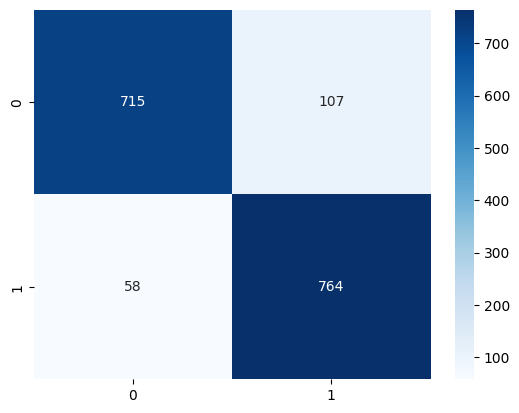

In [340]:
y_pred_train = GBC.predict(x_train_PCA)
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [341]:
print(classification_report(y_train, y_pred_train))

accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       822
           1       0.88      0.93      0.90       822

    accuracy                           0.90      1644
   macro avg       0.90      0.90      0.90      1644
weighted avg       0.90      0.90      0.90      1644

accuracy = 0.90
racall = 0.93
precision = 0.88
F1_Score = 0.90


<Axes: >

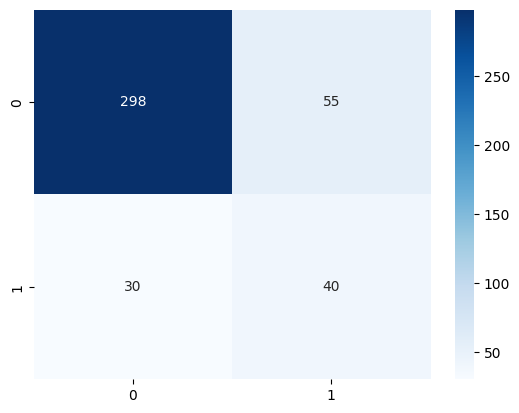

In [342]:
y_pred = GBC.predict(x_test_PCA)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [343]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.91      0.84      0.88       353
           1       0.42      0.57      0.48        70

    accuracy                           0.80       423
   macro avg       0.66      0.71      0.68       423
weighted avg       0.83      0.80      0.81       423

accuracy = 0.80
racall = 0.57
precision = 0.42
F1_Score = 0.48


## XGBoost

In [361]:
XGB = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.01,
    n_estimators=350,
    max_depth=3,
    random_state=42,
    max_features='sqrt',
)

XGB.fit(x_train_PCA, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_features='sqrt',
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=350,
              n_jobs=None, num_parallel_tree=None, ...)

<Axes: >

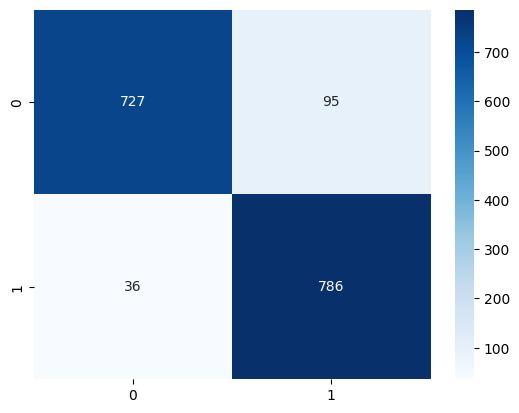

In [362]:
y_pred_train = XGB.predict(x_train_PCA)
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [363]:
print(classification_report(y_train, y_pred_train))
accuracy = accuracy_score(y_train, y_pred_train)
racall = recall_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
F1_Score = f1_score(y_train, y_pred_train)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.95      0.88      0.92       822
           1       0.89      0.96      0.92       822

    accuracy                           0.92      1644
   macro avg       0.92      0.92      0.92      1644
weighted avg       0.92      0.92      0.92      1644

accuracy = 0.92
racall = 0.96
precision = 0.89
F1_Score = 0.92


<Axes: >

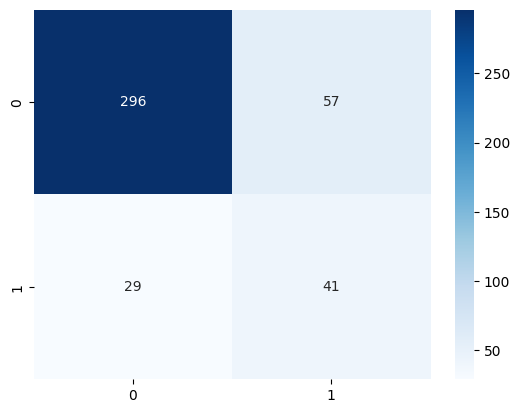

In [364]:
y_pred = XGB.predict(x_test_PCA)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

In [365]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
racall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy:.2f}')
print(f'racall = {racall:.2f}')
print(f'precision = {precision:.2f}')
print(f'F1_Score = {F1_Score:.2f}')

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       353
           1       0.42      0.59      0.49        70

    accuracy                           0.80       423
   macro avg       0.66      0.71      0.68       423
weighted avg       0.83      0.80      0.81       423

accuracy = 0.80
racall = 0.59
precision = 0.42
F1_Score = 0.49
